In [45]:
!head data/ua.test

1	20	4	887431883
1	33	4	878542699
1	61	4	878542420
1	117	3	874965739
1	155	2	878542201
1	160	4	875072547
1	171	5	889751711
1	189	3	888732928
1	202	5	875072442
1	265	4	878542441


In [46]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [47]:
# 1,20,4,887431883 csv
train = pd.read_csv("data/ua.base", sep="\t", names=['user', 'movie','ratings','timestamp'])
test = pd.read_csv("data/ua.test", sep="\t", names=['user', 'movie','ratings','timestamp'])

In [48]:
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['ratings'])

items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['ratings'])

In [80]:
rank = 100 #크면 학습이 잘될 확률이 높음(무조건X)(시간도 증가)
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad = True)
Q = torch.randn(numUsers, rank, requires_grad=True)

# 3 user 123 movie 예상:
#torch.sum(P[123] * Q[3])

optimizer = torch.optim.Adam([P,Q],lr=0.1)
X = []
Y = []
Y_test = []

#lambda가 작을수록 cost가 줄어든다.
#하지만 일정이상 작아지면 cost_test는 커진다.
lambda1 = 0.0001
lambda2 = 0.0001
# bias를 위한 람다
lambda3 = 0.0001
lambda4 = 0.0001
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum()/len(ratings)).item()

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users],dim=1) + \
                mean + bias_item[items] + bias_user[users]
  cost = F.mse_loss(hypothesis,ratings)
  #sum을 mean으로 바꾸면 cost는 줄어드는데 cost_test는 증가함 (over fitting)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q**2) + \
          lambda3 * torch.sum(bias_item** 2) + lambda4 * torch.sum(bias_user ** 2)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test],dim=1) + \
                mean + bias_item[items_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)


    X.append(epoch)
    Y.append(cost.item())
    Y_test.append(cost_test)

  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost:{cost.item():6f}")

# torch.sum(P[1] * Q[1]) # 1번유저가 1번영화에 줄 점수 예측

epoch: 0, cost:102.633652
epoch: 100, cost:0.323745
epoch: 200, cost:0.296167
epoch: 300, cost:0.289239
epoch: 400, cost:0.286876
epoch: 500, cost:0.286019
epoch: 600, cost:0.285652
epoch: 700, cost:0.285457
epoch: 800, cost:0.285340
epoch: 900, cost:0.285266
epoch: 1000, cost:0.285218


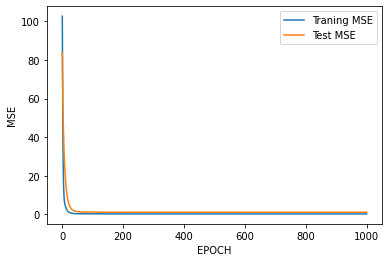

In [81]:
plt.ylabel("MSE")
plt.xlabel("EPOCH")
plt.plot(X,Y, label="Traning MSE")
plt.plot(X,Y_test, label = "Test MSE")
plt.legend()
plt.show()